# summary statistics and  stock regress against Toronto Stock Exchange (TSX)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
def compute_summary_stats(returns):
    summary_stats = returns.describe()
    summary_stats['Mean'] = returns.mean()
    summary_stats['Median'] = returns.median()
    summary_stats['Maximum'] = returns.max()
    summary_stats['Standard Deviation'] = returns.std()
    return summary_stats

def compute_annualized_stats(returns):
    annualized_mean = (1 + returns.mean()) ** 250 - 1
    annualized_std = returns.std() * (250 ** 0.5)
    return annualized_mean, annualized_std

def compute_cumulative_returns(returns):
    cumulative_returns = (1 + returns).cumprod()-1
    return cumulative_returns

def compute_cumulative_log_returns(log_returns):
    cumulative_returns = np.exp(log_returns.cumsum()) - 1
    return cumulative_returns

def compute_regression_stats(returns, benchmark):
    X = sm.add_constant(benchmark.values)
    model = sm.OLS(returns.values, X).fit()
    beta = model.params[1]
    r_squared = model.rsquared
    return beta, r_squared

def return_summary_stats(selected_start_date, selected_end_date, selected_interval, target_list):
    all_stats = pd.DataFrame()
    cumulative_returns_df = pd.DataFrame()
    daily_returns_df = pd.DataFrame()

    # Download the benchmark data (S&P/TSX Composite index)
    benchmark_data = yf.download(tickers=benchmark_ticker,
                                 start=selected_start_date,
                                 end=selected_end_date,
                                 interval=selected_interval,
                                 progress=False)
    #log retrun
    benchmark = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1)).dropna()
    #simple retrun
    #benchmark = benchmark_data['Adj Close'].pct_change().dropna()

    for ticker in target_list:
        # Download data for the current ticker
        data = yf.download(tickers=ticker,
                           start=selected_start_date,
                           end=selected_end_date,
                           interval=selected_interval,
                           progress=False)
        #log retrun
        all_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()
        #simple retrun
        #all_returns = data['Adj Close'].pct_change().dropna()


        daily_returns_df[ticker] = all_returns

        #log return cumulative return
        cumulative_returns = compute_cumulative_log_returns(all_returns)
        #simple retrun cumulative return
        #cumulative_returns = compute_cumulative_returns(all_returns)

        # Compute summary stats for the current ticker
        summary_stats = compute_summary_stats(all_returns)

        # Compute annualized statistics
        annualized_mean, annualized_std = compute_annualized_stats(all_returns)

        # Compute regression statistics
        beta, r_squared = compute_regression_stats(all_returns, benchmark)

        # Add annualized and regression statistics to the summary stats DataFrame
        summary_stats.loc['Annualized Mean'] = annualized_mean
        summary_stats.loc['Annualized Std'] = annualized_std
        summary_stats.loc['Beta'] = beta
        summary_stats.loc['R-squared'] = r_squared

        all_stats = pd.concat([all_stats, summary_stats], axis=1)
        cumulative_returns_df[ticker] = cumulative_returns

    # Plot cumulative returns for all target stocks
    cumulative_returns_df.plot(figsize=(10, 6))
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns for Selected Tickers')
    plt.legend()
    plt.show()

    all_stats.columns = target_list
    return all_stats, cumulative_returns_df, daily_returns_df

def compute_portfolio_composition(initial_investment, portfolio_weights,daily_returns_df):
    portfolio_composition =(1+daily_returns_df) * portfolio_weights * initial_investment
    portfolio_market_value = portfolio_composition.sum(axis=1)
    portfolio_composition_pct = portfolio_composition.divide(portfolio_market_value, axis=0) * 100

    # Plot the stacked bar chart for the portfolio composition
    plt.figure(figsize=(10, 6))
    portfolio_composition_pct.plot(kind='bar', stacked=True)
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.title('Portfolio Composition')
    plt.legend()

    years = portfolio_composition_pct.index.year
    months = portfolio_composition_pct.index.strftime('%b')

    # Select a subset of years and months to display on the x-axis
    step_size = max(len(years) // 10, 1)
    visible_years = years[::step_size]
    visible_months = months[::step_size]

    # Set the x-axis tick labels to display the selected years and months
    plt.xticks(range(0, len(years), step_size), [f'{year}\n{month}' for year, month in zip(visible_years, visible_months)])

    plt.show()

    returns = portfolio_market_value.pct_change()

    portfolio_stats = compute_summary_stats(returns)
    annualized_mean, annualized_std = compute_annualized_stats(returns)
    portfolio_stats.loc['Annualized Mean'] = annualized_mean
    portfolio_stats.loc['Annualized Std'] = annualized_std

    last_date_composition_pct = portfolio_composition_pct.iloc[-1]
    constant_returns = last_date_composition_pct * daily_returns_df
    constant_portfolio_daily_returns = constant_returns.sum(axis=1) / 100

    constant_portfolio_stats = compute_summary_stats(constant_portfolio_daily_returns)
    annualized_mean, annualized_std = compute_annualized_stats(constant_portfolio_daily_returns)
    constant_portfolio_stats.loc['Annualized Mean'] = annualized_mean
    constant_portfolio_stats.loc['Annualized Std'] = annualized_std

    #-------------------------
    # Plot portfolio composition percentage for all target stocks
    portfolio_composition_pct.plot(figsize=(10, 6))
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns for Selected Tickers')
    plt.legend()
    plt.show()

    return portfolio_stats, constant_portfolio_stats,portfolio_composition,portfolio_market_value,portfolio_composition_pct

# setting up

In [3]:
target_list = ["RY.TO", "SHOP.TO", "CNQ.TO", "VCN.TO"]
benchmark_ticker = "^GSPTSE"

# Part B: Q1-Q2 summary statistics including regression resulte such as beta and R2

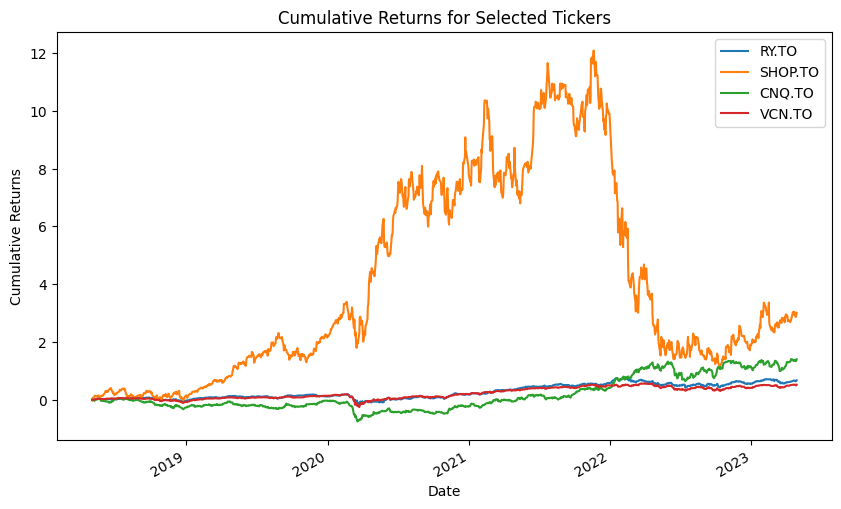

--- Summary Statistics ---
                          RY.TO      SHOP.TO       CNQ.TO       VCN.TO
count               1253.000000  1253.000000  1253.000000  1253.000000
mean                   0.000413     0.001109     0.000701     0.000336
std                    0.012765     0.039589     0.029519     0.011360
min                   -0.111359    -0.187569    -0.345035    -0.127120
25%                   -0.003944    -0.019042    -0.012108    -0.003630
50%                    0.000922     0.002806     0.000791     0.000943
75%                    0.005569     0.021542     0.014456     0.004858
max                    0.138860     0.158125     0.203858     0.115184
Mean                   0.000413     0.001109     0.000701     0.000336
Median                 0.000922     0.002806     0.000791     0.000943
Maximum                0.138860     0.158125     0.203858     0.115184
Standard Deviation     0.012765     0.039589     0.029519     0.011360
Annualized Mean        0.108689     0.319394     0

In [4]:
# Call return_summary_stats to get summary statistics, cumulative returns, and daily returns for all target stocks
summary_stats, cumulative_returns_df, daily_returns_df = return_summary_stats(selected_start_date='2018-05-01',
                                                                             selected_end_date='2023-04-29',
                                                                             selected_interval='1d',
                                                                             target_list=target_list)

# Print the summary statistics for all target stocks
print('--- Summary Statistics ---')
print(summary_stats)

# Print the daily returns and cumulative returns for all target stocks
print('\n--- Daily Returns ---')
print(daily_returns_df)

print('\n--- Cumulative Returns ---')
print(cumulative_returns_df)


# Part B: Q4 portfolio

<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


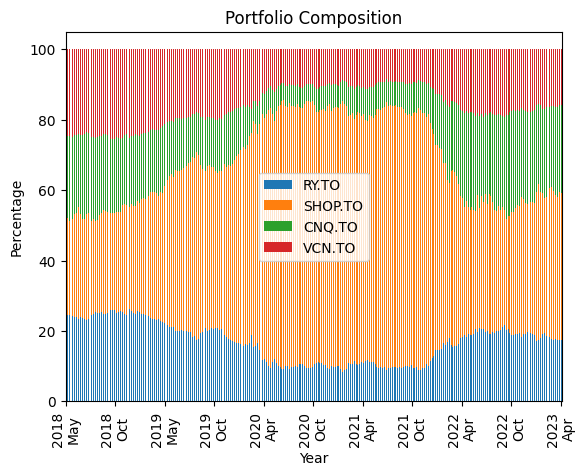

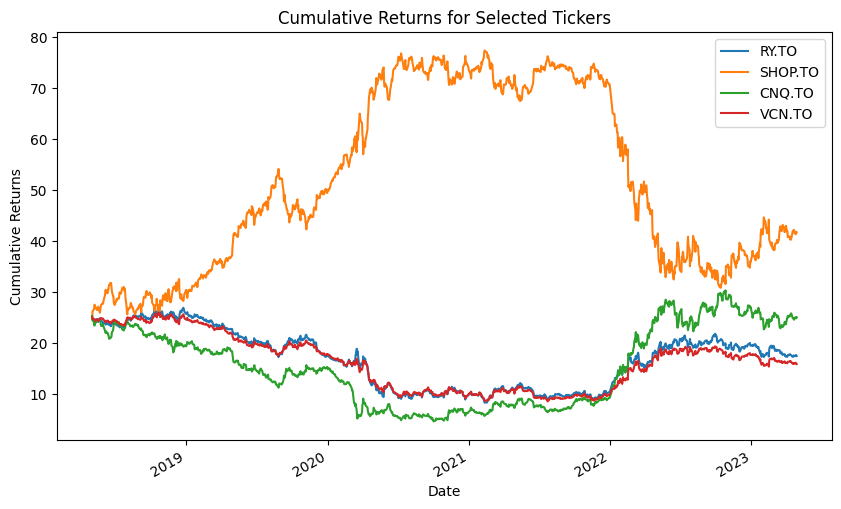


--- Portfolio Statistics ---
count                 1252.000000
mean                     0.000969
std                      0.023080
min                     -0.144257
25%                     -0.010884
50%                      0.001666
75%                      0.012241
max                      0.147271
Mean                     0.000969
Median                   0.001666
Maximum                  0.147271
Standard Deviation       0.023080
Annualized Mean          0.274015
Annualized Std           0.364924
dtype: float64

--- individual daily value ---
                   RY.TO        SHOP.TO        CNQ.TO        VCN.TO
Date                                                               
2018-05-02  25010.244341   24616.208800  25244.407528  25015.753982
2018-05-03  24997.445456   26527.523740  24695.852855  24992.116930
2018-05-04  25040.958336   26750.765185  24809.908035  25189.092944
2018-05-07  25279.001903   27301.221905  24603.524457  25299.400345
2018-05-08  25309.718276   28365.443673

In [5]:
# Call the function with initial investment and portfolio weights
initial_investment = 100000
portfolio_weights = [0.25, 0.25, 0.25, 0.25]
portfolio_stats, constant_portfolio_stats,portfolio_composition,portfolio_market_value,portfolio_composition_pct = compute_portfolio_composition(initial_investment, portfolio_weights,cumulative_returns_df)

# Print the summary statistics for the portfolio
print('\n--- Portfolio Statistics ---')
print(portfolio_stats)

print('\n--- individual daily value ---')
print(portfolio_composition)

print('\n--- portfolio daily value ---')
print(portfolio_market_value)

print('\n--- individual daily value percentage ---')
print(portfolio_composition_pct)


# Print the summary statistics for the constant portfolio composition
print('\n--- Constant Portfolio Statistics ---')
print(constant_portfolio_stats)